In [27]:
import numpy as np
import pandas as pd
import sys,os
sys.path.append(sys.path[0] + '/..')


import matplotlib.pyplot as plt
import matplotlib



from imp import reload
import platereaderclass as prc; reload(prc);
import plates_EstimateMSP as eMSP; reload(eMSP);

In [28]:
basedir = '/home/lukas/projects/antibiotics/experiments/200129_AllData/'

design_assignment_andy = {  'andy_WT.xlsx':         [0, 1, 2], 
                            'andy_TEM1.xlsx':       [0, 0, 1, 1, 2, 2], 
                            'andy_E104KG238S.xlsx': [0, 0, 1, 1, 2, 2],
                            'andy_G238S.xlsx':      [0, 0, 1, 1, 2, 2],
                            'andy_Triple.xlsx':     [0, 1, 2]}

design_assignment_philip = {'philip_G238S.xlsx':    [0, 0, 0, 0, 0, 0, 0, 0],
                            'philip_Triple.xlsx':   [0, 0, 1, 1, 1, 1, 0, 0]}


def make_argparse_options(filename,design_assignment):
    return ['-q','-i',basedir + filename.split('_')[0] + '/data/' + filename,'-M','NfuncB','BfuncN', '-D'] + [str(i) for i in design_assignment]

def AddDF(df1 = None,df2 = None):
    if df1 is None:    return df2
    elif df2 is None:  return df1
    else:              return pd.concat([df1,df2],ignore_index = True)

def split_allele_name_andy(df):
    def split_iptg(allele):
        if allele[-4:].upper() == 'IPTG': return [allele[:-5],allele[-5:]]
        else:                             return [allele,'+IPTG']
    data = [x.strip('andy') for x in df['Title'].values]
    data = np.array([['andy',split_iptg(x.split('_')[0])[0],split_iptg(x.split('_')[0])[1],x.split('_')[1]] for x in data])
    df['exp'] = 'andy'
    df['Allele'] = data[:,1]
    df['ExprLevel'] = data[:,2]
    df['Repetition'] = data[:,3]
    return df

def split_allele_name_philip(df):
    data = np.array([x.split('_') for x in df['Title'].values])
    df['exp'] = 'philip'
    df['Allele'] = data[:,0]
    df['ExprLevel'] = data[:,1]
    df['Repetition'] = data[:,2]
    return df

In [29]:
results_andy = None
for datafile in design_assignment_andy.keys():
    curres = eMSP.EstimateMSP(params = make_argparse_options(datafile,design_assignment_andy[datafile]))
    results_andy = AddDF(results_andy,curres)

results_philip = None
for datafile in design_assignment_philip.keys():
    curres = eMSP.EstimateMSP(params = make_argparse_options(datafile,design_assignment_philip[datafile]))
    results_philip = AddDF(results_philip,curres)
    
results = AddDF(split_allele_name_andy(results_andy),split_allele_name_philip(results_philip))
#results.drop(columns = ['Title','Filename'],inplace = True)

results

,Title,Filename,NB_sMIC,NB_sMIC_stddev,NB_tau,NB_tau_stddev,NB_R2,BN_sMIC,BN_sMIC_stddev,BN_tau,BN_tau_stddev,BN_R2,exp,Allele,ExprLevel,Repetition
0,andyWT_A,/home/lukas/projects/antibiotics/experiments/2...,0.057485,0.107967,1.721031e-07,1.509565e-07,0.565178,0.103859,0.133159,9.726884e-08,8.531728e-08,0.565178,andy,WT,+IPTG,A
1,andyWT_B,/home/lukas/projects/antibiotics/experiments/2...,0.043705,0.064954,2.603217e-07,1.708215e-07,0.699012,0.069469,0.080090,1.819680e-07,1.194063e-07,0.699012,andy,WT,+IPTG,B
2,andyWT_C,/home/lukas/projects/antibiotics/experiments/2...,0.056324,0.078849,1.883684e-07,1.311983e-07,0.673351,0.084102,0.090536,1.268380e-07,8.834245e-08,0.673351,andy,WT,+IPTG,C
3,TEM1-IPTG_A,/home/lukas/projects/antibiotics/experiments/2...,0.036567,0.023540,3.080493e-07,4.632864e-07,0.306577,0.044654,0.013181,9.444087e-08,1.420330e-07,0.306577,andy,TEM1,-IPTG,A
4,TEM1+IPTG_A,/home/lukas/projects/antibiotics/experiments/2...,0.034087,0.017761,2.486184e-07,3.243498e-07,0.370096,0.040912,0.010604,9.201257e-08,1.200404e-07,0.370096,andy,TEM1,+IPTG,A
5,TEM1-IPTG_B,/home/lukas/projects/antibiotics/experiments/2...,0.035006,0.043180,2.844460e-07,1.521564e-07,0.777520,0.050296,0.051579,2.211624e-07,1.183046e-07,0.777520,andy,TEM1,-IPTG,B
6,TEM1+IPTG_B,/home/lukas/projects/antibiotics/experiments/2...,0.037940,0.043730,2.827461e-07,1.435045e-07,0.795168,0.052398,0.051129,2.248307e-07,1.141103e-07,0.795168,andy,TEM1,+IPTG,B
7,TEM1-IPTG_C,/home/lukas/projects/antibiotics/experiments/2...,0.026702,0.024979,3.410337e-07,1.948223e-07,0.753949,0.035003,0.026807,2.571221e-07,1.468861e-07,0.753949,andy,TEM1,-IPTG,C
8,TEM1+IPTG_C,/home/lukas/projects/antibiotics/experiments/2...,0.036541,0.029496,3.137430e-07,1.347172e-07,0.844328,0.044504,0.031822,2.649021e-07,1.137456e-07,0.844328,andy,TEM1,+IPTG,C
9,E104KG238S-IPTG_A,/home/lukas/projects/antibiotics/experiments/2...,0.516232,0.369723,1.047349e-06,4.655603e-07,0.835009,0.621101,0.389914,8.745455e-07,3.887470e-07,0.835009,andy,E104KG238S,-IPTG,A


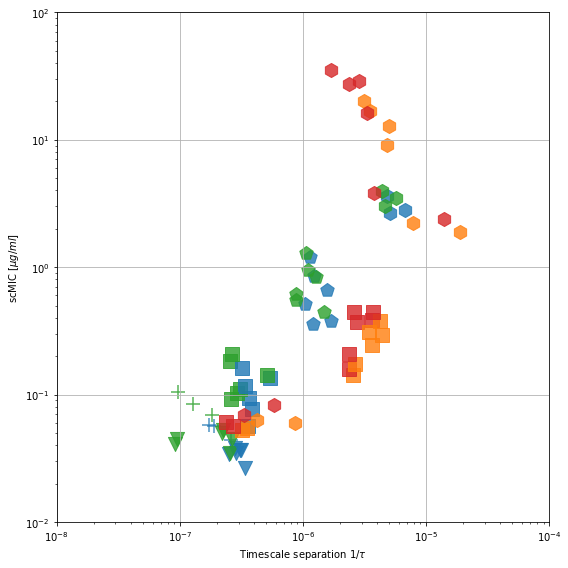

In [30]:
fig,ax = plt.subplots(1,1,figsize = (8,8))

colors1 = {'andy':'TAB:BLUE','philip':'TAB:ORANGE'}
colors2 = {'andy':'TAB:GREEN','philip':'TAB:RED'}
alleles = {'WT':'+','TEM1':'v','G238S':'s','E104KG238S':'p','Triple':'h'}
exprlevel = {'-IPTG':'none','+IPTG':'full','None':'none','Low':'top','Med':'bottom','High':'full'}

for index,experiment in results.iterrows():
    ax.scatter(experiment['NB_tau'],experiment['NB_sMIC'],c = colors1[experiment['exp']], marker = alleles[experiment['Allele']], s = 200,alpha = .8)
    ax.scatter(experiment['BN_tau'],experiment['BN_sMIC'],c = colors2[experiment['exp']], marker = alleles[experiment['Allele']], s = 200,alpha = .8)

    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e-8,1e-4])
ax.set_ylim([1e-2,1e2])
ax.set_xlabel(r'Timescale separation $1/\tau$')
ax.set_ylabel(r'scMIC $[\mu g/ml]$')
ax.grid()
fig.tight_layout()
fig.savefig('tau_smic.pdf')

In [76]:
def grid2design(gridcoordinates, plate_size, griddesign = (12.,8.)):
    if isinstance(gridcoordinates[0],(list,tuple,np.ndarray)):
        return np.array([grid2design(gc,plate_size, griddesign) for gc in gridcoordinates])
    else:
        return np.array([ 
                plate_size['Bmin'] * np.power(plate_size['Bmax']/plate_size['Bmin'],gc[0]/(griddesign[0]-1.)),
                plate_size['Nmin'] * np.power(plate_size['Nmax']/plate_size['Nmin'],1. - gc[1]/(griddesign[1]-1.))
            ])


def design2grid(designcoordinates, plate_size, griddesign = (12.,8.)):
    return np.array([[
        (griddesign[0]-1) * (np.log(dc[0]/plate_size['Bmin']))/np.log(plate_size['Bmax']/plate_size['Bmin']),
        (griddesign[1]-1) * (1 - (np.log(dc[1]/plate_size['Nmin']))/np.log(plate_size['Nmax']/plate_size['Nmin']))
    ] for dc in designcoordinates])
    

def adjust_ax(ax, plate_size, fc = '#d3d7cf'):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    xticks = [1e-2,1e-1,1e0,1e1]
    yticks = [1e3,1e5,1e7]
    
    xtickpos = design2grid(np.array([xticks,np.ones_like(xticks)]).T, plate_size = plate_size)[:,0]
    ytickpos = design2grid(np.array([np.ones_like(yticks),yticks]).T, plate_size = plate_size)[:,1]

    ax.set_xticks(xtickpos)
    ax.set_xticklabels([r'$10^{{{:d}}}$'.format(int(np.log10(x))) for x in xticks])
    ax.set_yticks(ytickpos)
    ax.set_yticklabels([r'$10^{{{:d}}}$'.format(int(np.log10(y))) for y in yticks])

    ax.set_xlim([-.6,11.6])
    ax.set_ylim([7.6,-.6])
    
    background = matplotlib.patches.Rectangle([ax.get_xlim()[0],ax.get_ylim()[0]],np.diff(ax.get_xlim()),np.diff(ax.get_ylim()), fc = fc, zorder = -1)
    ax.add_patch(background)

    ax.set_xlabel(r'Initial Antibiotic Concentration $B_0$ $[\mu g/ml]$')
    ax.set_ylabel(r'Inoculum size $N_0$')
    
    
def patch_color(value):
    if value < 0: value = 0
    if value > 1: value = 1
    blue = [ 65,101,164]
    gray = [255,255,255]
    return '#{:02X}{:02X}{:02X}'.format(int(blue[0] * value + gray[0] * (1-value)),int(blue[1] * value + gray[1] * (1-value)),int(blue[2] * value + gray[2] * (1-value)))
    

def plot_well(ax, pos, value, thres, plate_pos, plate_data_shape, radius = 0.4):
    border_color = '#2e3436'
    if value <= thres:
        border_color = '#a40000'
    circle = matplotlib.patches.Circle(pos,radius,facecolor = patch_color(value), edgecolor = border_color, linewidth = 3)
    ax.add_patch(circle)

    
def rescale(platedata, threshold):
    return (platedata - np.min(platedata))/(np.max(platedata) - np.min(platedata)),(threshold - np.min(platedata))/(np.max(platedata)-np.min(platedata))


def BfuncN(N, tau, smic): return smic*np.exp((N-1)/tau)
def NfuncB(B, tau, smic): return 1 + tau * np.log(B/smic)



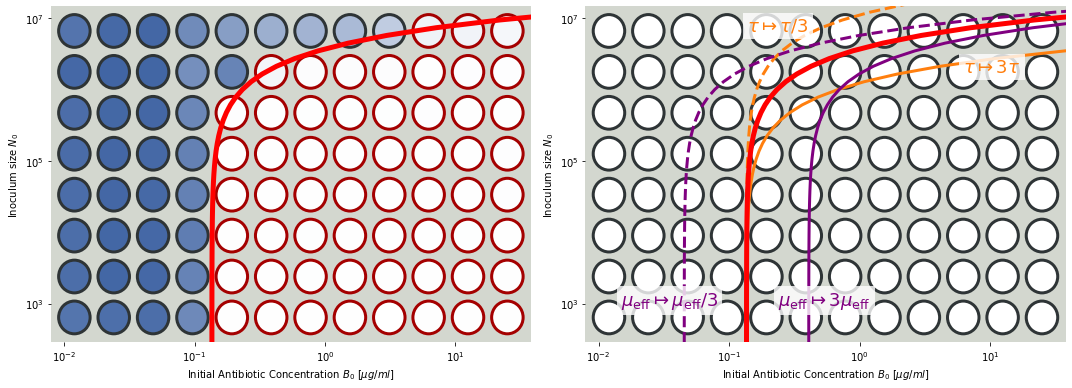

In [112]:
filename             = basedir + 'andy/data/andy_G238S.xlsx'
experiment_index     = 1
experiment_data      = prc.PlateReaderData(infiles = [filename])
platedata, threshold = rescale(experiment_data[experiment_index].T, experiment_data.EstimateGrowthThreshold())
design               = experiment_data.get_design(0)
plate_size           = {'Nmin':np.min(design[1]), 'Nmax':np.max(design[1]), 'Bmin':np.min(design[0]), 'Bmax':np.max(design[0])}
estimates            = results[results['Filename'] == filename].iloc[experiment_index,:]
fig, ax              = plt.subplots(1,2,figsize = (15,5.5))

color_change_tau = 'tab:orange'
color_change_mu  = 'purple'

for x in range(platedata.shape[0]):
    for y in range(platedata.shape[1]):
        plot_well(ax[0], [x,y], platedata[x,y], threshold, plate_size, platedata.shape)
        plot_well(ax[1], [x,y],              0,        -1, plate_size, platedata.shape)

nlist             = np.exp(np.linspace(np.log(1e2),np.log(2e7),num=50))
mspcurve          = design2grid(np.array([BfuncN(nlist,1/estimates['NB_tau'],estimates['NB_sMIC']),nlist]).T, plate_size)

scalefactor       = 3.
mspcurve_tau_inc  = design2grid(np.array([BfuncN(nlist,(1./scalefactor)/estimates['NB_tau'],estimates['NB_sMIC']),nlist]).T, plate_size)
mspcurve_tau_dec  = design2grid(np.array([BfuncN(nlist,scalefactor/estimates['NB_tau'],estimates['NB_sMIC']),nlist]).T, plate_size)
mspcurve_smic_inc = design2grid(np.array([BfuncN(nlist,1/estimates['NB_tau'],scalefactor*estimates['NB_sMIC']),nlist]).T, plate_size)
mspcurve_smic_dec = design2grid(np.array([BfuncN(nlist,1/estimates['NB_tau'],(1./scalefactor)*estimates['NB_sMIC']),nlist]).T, plate_size)

ax[0].plot(mspcurve[:,0],mspcurve[:,1], lw = 5, c = 'red', zorder = 100)
ax[1].plot(mspcurve[:,0],mspcurve[:,1], lw = 5, c = 'red', zorder = 100)
ax[1].plot(mspcurve_tau_inc[:,0],  mspcurve_tau_inc[:,1],  lw = 3, c = color_change_tau)
ax[1].plot(mspcurve_tau_dec[:,0],  mspcurve_tau_dec[:,1],  lw = 3, c = color_change_tau, linestyle = '--')
ax[1].plot(mspcurve_smic_inc[:,0], mspcurve_smic_inc[:,1], lw = 3, c = color_change_mu)
ax[1].plot(mspcurve_smic_dec[:,0], mspcurve_smic_dec[:,1], lw = 3, c = color_change_mu, linestyle = '--')

ax[1].annotate(r'$\tau\mapsto{}\tau$'.format(int(scalefactor)),                              [9.0,1.0], c = color_change_tau, fontsize = 18, weight = 'bold').set_bbox({'facecolor': 'white', 'alpha': .8,'edgecolor': None, 'linewidth': 0})
ax[1].annotate(r'$\tau\mapsto\tau/{}$'.format(int(scalefactor)),                             [3.5,0.0], c = color_change_tau, fontsize = 18, weight = 'bold').set_bbox({'facecolor': 'white', 'alpha': .8,'edgecolor': None, 'linewidth': 0})
ax[1].annotate(r'$\mu_\mathrm{{eff}}\mapsto{}\mu_\mathrm{{eff}}$'.format(int(scalefactor)),  [4.3,6.7], c = color_change_mu,  fontsize = 18, weight = 'bold').set_bbox({'facecolor': 'white', 'alpha': .8,'edgecolor': None, 'linewidth': 0})
ax[1].annotate(r'$\mu_\mathrm{{eff}}\mapsto\mu_\mathrm{{eff}}/{}$'.format(int(scalefactor)), [0.3,6.7], c = color_change_mu,  fontsize = 18, weight = 'bold').set_bbox({'facecolor': 'white', 'alpha': .8,'edgecolor': None, 'linewidth': 0})

adjust_ax(ax[0], plate_size)
adjust_ax(ax[1], plate_size)
fig.tight_layout()

fig.savefig('platedata.pdf')